In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('SBAnational.csv')

df=df.drop(columns=['LoanNr_ChkDgt','Name','City','State','Zip','Bank','BankState','ChgOffDate','ChgOffPrinGr','ApprovalDate','DisbursementDate','ApprovalFY','BalanceGross'],axis=1)
df=df.dropna()
df.head()

C:\Users\dell\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,MIS_Status,GrAppv,SBA_Appv
0,451120,84,4,2.0,0,0,1,0,N,Y,"$60,000.00",P I F,"$60,000.00","$48,000.00"
1,722410,60,2,2.0,0,0,1,0,N,Y,"$40,000.00",P I F,"$40,000.00","$32,000.00"
2,621210,180,7,1.0,0,0,1,0,N,N,"$287,000.00",P I F,"$287,000.00","$215,250.00"
3,0,60,2,1.0,0,0,1,0,N,Y,"$35,000.00",P I F,"$35,000.00","$28,000.00"
4,0,240,14,1.0,7,7,1,0,N,N,"$229,000.00",P I F,"$229,000.00","$229,000.00"


In [3]:
df['Defaulted'] = [-1 if app == 'CHGOFF' else 1 for app in df.MIS_Status.values]
df['LowDoc'] = [-1 if app == 'N' else 1 for app in df.LowDoc.values]
df['RevLineCr'] = [-1 if app == 'N' else 1 for app in df.RevLineCr.values]
df = df.drop(columns=['MIS_Status'])

In [4]:
money_cols = ['DisbursementGross', 'GrAppv', 'SBA_Appv']
for col in money_cols:
    df[col] = df[col].str.replace('$', '')
    df[col] =[float(val[1:].replace(',', '')) for val in df[col].values]
df

<ipython-input-4-56eca1410deb>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('$', '')


,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,Defaulted
0,451120,84,4,2.0,0,0,1,0,-1,1,0.0,0.0,8000.0,1
1,722410,60,2,2.0,0,0,1,0,-1,1,0.0,0.0,2000.0,1
2,621210,180,7,1.0,0,0,1,0,-1,-1,87000.0,87000.0,15250.0,1
3,0,60,2,1.0,0,0,1,0,-1,1,5000.0,5000.0,8000.0,1
4,0,240,14,1.0,7,7,1,0,-1,-1,29000.0,29000.0,29000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,451120,60,6,1.0,0,0,1,0,1,-1,0.0,0.0,6000.0,1
899160,451130,60,6,1.0,0,0,1,0,1,-1,5000.0,5000.0,2500.0,1
899161,332321,108,26,1.0,0,0,1,0,-1,-1,0.0,0.0,25000.0,1
899162,0,60,6,1.0,0,0,1,0,-1,1,5000.0,5000.0,0.0,-1


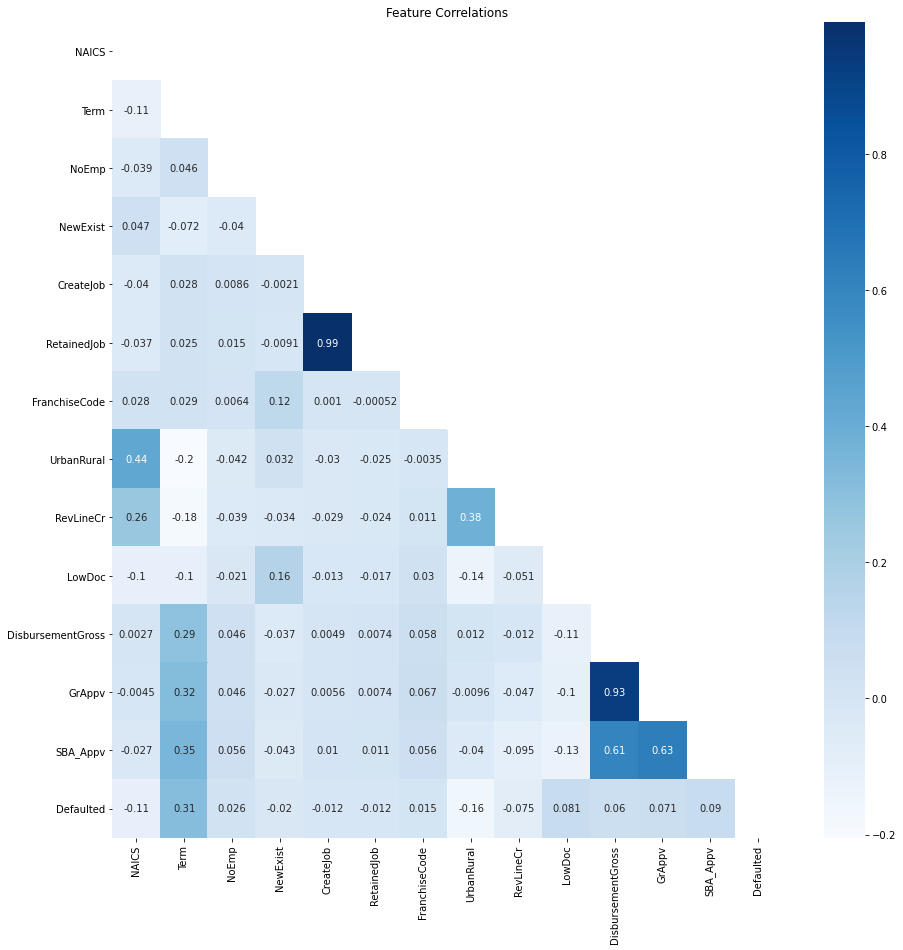

In [5]:
#Term and DisbursementGross have a strong positive correlation (.47), which means that loans with larger terms are usually large.
#positive realiotnship between Retainedjob and Creatjob.
import matplotlib.pyplot as plt
import seaborn as sns
corr = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot = True, ax=ax, mask=mask, cmap = "Blues").set(title='Feature Correlations')
plt.show()

C:\Users\dell\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


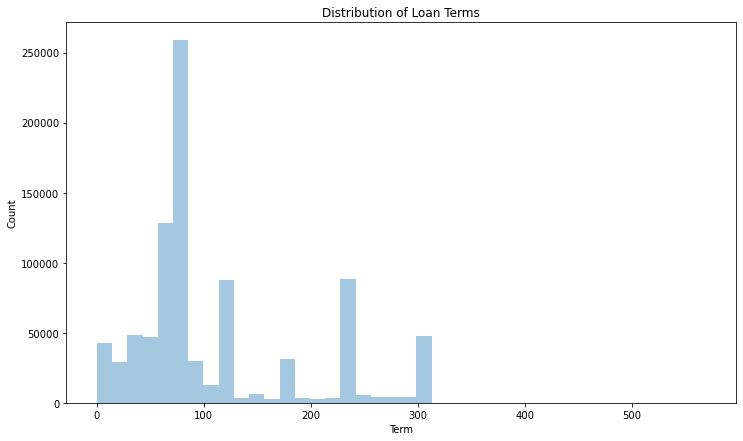

In [6]:
#The distribution of loan terms isn't quite normal, so we might want to consider scaling it later.
#There seems to be popular loan terms around the 100, 250 and 300 month marks.
fig = plt.figure(figsize=(12,7))
sns.distplot(a=df['Term'], bins = 40,kde=False)
plt.title('Distribution of Loan Terms')
plt.ylabel('Count')
plt.show()

In [7]:
X=df.drop(columns=['Defaulted'])
y=df.Defaulted

df.head(20)
print(X)
print(y)

         NAICS  Term  NoEmp  NewExist  CreateJob  RetainedJob  FranchiseCode  \
0       451120    84      4       2.0          0            0              1   
1       722410    60      2       2.0          0            0              1   
2       621210   180      7       1.0          0            0              1   
3            0    60      2       1.0          0            0              1   
4            0   240     14       1.0          7            7              1   
...        ...   ...    ...       ...        ...          ...            ...   
899159  451120    60      6       1.0          0            0              1   
899160  451130    60      6       1.0          0            0              1   
899161  332321   108     26       1.0          0            0              1   
899162       0    60      6       1.0          0            0              1   
899163       0    48      1       2.0          0            0              1   

        UrbanRural  RevLineCr  LowDoc  

In [8]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [9]:
X_train.head(14)

,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv
44783,532230,84,3,2.0,0,0,1,0,-1,1,0.0,0.0,0.0
409074,0,180,2,2.0,2,2,1,1,1,-1,56500.0,56500.0,17375.0
488175,332812,240,24,1.0,24,71,1,1,-1,-1,46000.0,46000.0,46000.0
738924,423310,240,76,1.0,25,76,1,1,1,-1,287000.0,287000.0,287000.0
613603,621310,84,3,1.0,0,3,1,1,1,-1,0.0,0.0,5000.0
822667,0,84,2,1.0,0,0,1,0,-1,1,7000.0,7000.0,3600.0
554801,333311,60,2,2.0,0,0,1,1,1,1,0.0,0.0,2500.0
500445,443120,120,45,1.0,10,45,0,1,-1,-1,48600.0,48600.0,4300.0
242574,541519,220,40,1.0,24,16,1,1,1,-1,92000.0,10000.0,82500.0
164032,441110,84,6,1.0,1,7,1,1,1,-1,3020.0,5000.0,7500.0


In [10]:
y_train.head()

44783     1
409074    1
488175    1
738924    1
613603    1
Name: Defaulted, dtype: int64

In [11]:
#model training
#higher epochs will oftn result in more accurate model
#model.fit(X_train,y_train,epochs=200,batch_size=32)
#improving Accuracy try training for 500 epochs, we should see the accuray
#increase to 0.8 on this dataset and model setup
random_model = RandomForestRegressor(n_estimators=10)
random_model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10)

In [12]:
y_hat=random_model.predict(X_test)
y_hat=[0 if val <0.5 else 1 for val in y_hat]

0.7572364429062634